# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [1]:
# Update the PATH to include the user installation directory. 
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"

# Restart the Kernel before you move on to the next step.

#### Important: Restart the Kernel before you move on to the next step.

In [3]:
# Install requirements
#!python -m pip install -r requirements.txt

## Imports

In [72]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torchvision
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [73]:
# Define transforms
transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5,), (0.5,))
                             ])

# Create training set and define training dataloader
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform=transform),
  batch_size=500, shuffle=True)

# Create test set and define test dataloader
test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform=transform),
  batch_size=500, shuffle=False)

## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

**Here transformations are applied to the data before it's used for training or testing which converts the data into PyTorch tensors and normalize with ((mean=0.5,), sd=(0.5,)): This transformation normalizes the tensor data. It subtracts a mean value of 0.5 and divides by a standard deviation of 0.5. This normalization is used to scale the  values of the images to a range between -1 and 1. There are lots of other transformations that we can do using torchvision.transforms like Reshaping, croping, etc but i didnot transform since MNIST is a very primitive dataset.**

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [74]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

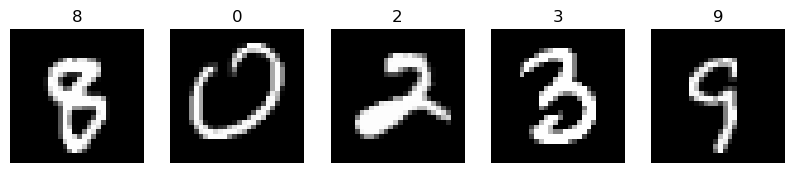

In [75]:
# Explore data
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig, subs = plt.subplots(1, 5, figsize=(10, 2))
for idx, sub in zip(np.arange(5), subs.flatten()):
    sub.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    sub.set_title(str(labels[idx].item()))
    sub.axis("off")

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [76]:
## YOUR CODE HERE ##
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        # Define the layers of your neural network
        self.flatten = nn.Flatten()  # Flatten layer to convert 2D image data to 1D
        self.fc1 = nn.Linear(28 * 28, 128)  # Fully connected layer 1
        self.fc2 = nn.Linear(128, 64)       # Fully connected layer 2
        self.fc3 = nn.Linear(64, 10)        # Fully connected layer 3 (output layer)
    
    def forward(self, x):
        # Forward pass through the network
        x = self.flatten(x)    # Flatten the input
        x = F.relu(self.fc1(x))  # Apply ReLU activation to first layer
        x = F.relu(self.fc2(x))  # Apply ReLU activation to second layer
        x = self.fc3(x)         # Output layer (no activation here)
        return x

# Create an instance of your model
network = MyModel()

# Print the model architecture
print(network)

MyModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [77]:
## YOUR CODE HERE ##
#Hyperparameter of model

# Define hyperparameters
n_epochs = 10
learning_rate = 0.01
momentum = 0.5
log_interval = 250  # Print loss after every 250 batches

# Initialize your model
network = MyModel()

# loss function as Cross-Entropy Loss, which is appropriate for multi-class classification problems.
criterion = nn.CrossEntropyLoss()

# #Here, I used SGD(Stochastic Gradient Descent) optimizer
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [78]:
## YOUR CODE HERE ##
# Training loop without GPU
train_losses = []  # To store training losses
total_batches = len(train_loader)

for epoch in range(1, n_epochs + 1):
    network.train()  # Set the model in training mode
    running_loss = 0.0
    
    for batch_idx, (data, target) in enumerate(train_loader, start=1):
        optimizer.zero_grad()
        output = network(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if batch_idx % log_interval == 0 or batch_idx == total_batches:
            average_loss = running_loss / log_interval
            print(f'Epoch [{epoch}/{n_epochs}] Batch [{batch_idx}/{total_batches}] Loss: {average_loss:.4f}')
            train_losses.append(average_loss)
            running_loss = 0.0

Epoch [1/10] Batch [120/120] Loss: 0.9664
Epoch [2/10] Batch [120/120] Loss: 0.5045
Epoch [3/10] Batch [120/120] Loss: 0.2950
Epoch [4/10] Batch [120/120] Loss: 0.2296
Epoch [5/10] Batch [120/120] Loss: 0.2002
Epoch [6/10] Batch [120/120] Loss: 0.1835
Epoch [7/10] Batch [120/120] Loss: 0.1729
Epoch [8/10] Batch [120/120] Loss: 0.1646
Epoch [9/10] Batch [120/120] Loss: 0.1583
Epoch [10/10] Batch [120/120] Loss: 0.1531


Plot the training loss (and validation loss/accuracy, if recorded).

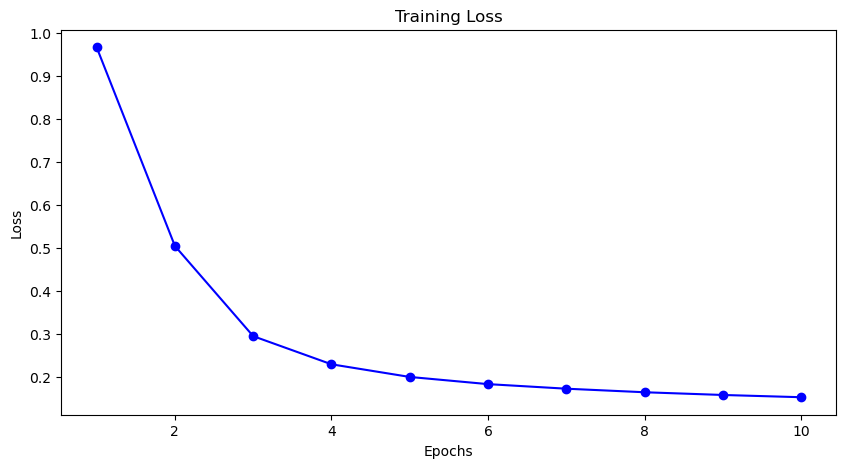

In [79]:
## YOUR CODE HERE ##
# Plot the training loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', linestyle='-', color='b')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [80]:
## YOUR CODE HERE ##
def calculate_accuracy(model, dataloader):
    model.eval()  # Set the model in evaluation mode
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in dataloader:
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    accuracy = (100 * correct) / total
    return accuracy

# print the test accuracy after training the model.
test_accuracy = calculate_accuracy(network, test_loader)
print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 91.23%


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [81]:
## YOUR CODE HERE ##
# Tweaking hyperparameters
n_epochs = 15  # Increase the number of epochs
learning_rate = 0.001  # Decrease the learning rate
momentum = 0.9  # Increase momentum
log_interval = 250

# Training loop
train_losses = []  
total_batches = len(train_loader)

for epoch in range(1, n_epochs + 1):
    network.train()  
    running_loss = 0.0
    
    for batch_idx, (data, target) in enumerate(train_loader, start=1):
        optimizer.zero_grad()
        output = network(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if batch_idx % log_interval == 0 or batch_idx == total_batches:
            average_loss = running_loss / log_interval
            print(f'Epoch [{epoch}/{n_epochs}] Batch [{batch_idx}/{total_batches}] Loss: {average_loss:.4f}')
            train_losses.append(average_loss)
            running_loss = 0.0

# Calculate and print the test accuracy
test_accuracy = calculate_accuracy(network, test_loader)
print(f'Test Accuracy: {test_accuracy:.2f}%')


Epoch [1/15] Batch [120/120] Loss: 0.1487
Epoch [2/15] Batch [120/120] Loss: 0.1449
Epoch [3/15] Batch [120/120] Loss: 0.1414
Epoch [4/15] Batch [120/120] Loss: 0.1382
Epoch [5/15] Batch [120/120] Loss: 0.1349
Epoch [6/15] Batch [120/120] Loss: 0.1321
Epoch [7/15] Batch [120/120] Loss: 0.1291
Epoch [8/15] Batch [120/120] Loss: 0.1262
Epoch [9/15] Batch [120/120] Loss: 0.1237
Epoch [10/15] Batch [120/120] Loss: 0.1211
Epoch [11/15] Batch [120/120] Loss: 0.1184
Epoch [12/15] Batch [120/120] Loss: 0.1159
Epoch [13/15] Batch [120/120] Loss: 0.1134
Epoch [14/15] Batch [120/120] Loss: 0.1113
Epoch [15/15] Batch [120/120] Loss: 0.1088
Test Accuracy: 93.61%


## Saving your model
Using `torch.save`, save your model for future loading.

In [82]:
## YOUR CODE HERE ##
# Save the trained model
torch.save(network, './results/model.pth')